# Feature Engineering

## 1. Importación de Librerías

In [40]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
from tabulate import tabulate

# Calendario de mercados
import pandas_market_calendars as mcal

In [41]:
#IMPORTACIÓN DE LIBRERÍAS 

# -------------------------
# Utilidades generales
# -------------------------
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Manejo y procesamiento de datos
# -------------------------
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# Calendario de mercados
# -------------------------
import pandas_market_calendars as mcal

# -------------------------
# Estadística y series temporales
# -------------------------
##from statsmodels.tsa.stattools import adfuller
##from statsmodels.graphics.tsaplots import plot_predict
##from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA
##from statsmodels.tsa.seasonal import seasonal_decompose
##from pmdarima.arima import ARIMA as pm_ARIMA
##import pmdarima as pm
##from arch import arch_model

# -------------------------
# Modelado con LSTM
# -------------------------
##from keras.models import Sequential
##from keras.layers import LSTM, Dense, Dropout
##from keras.preprocessing.sequence import TimeseriesGenerator

# -------------------------
# Paralelización
# -------------------------
##from joblib import parallel_backend


## 2. Carga del dataset mnq_intraday_data

In [42]:
def cargar_df():
    #path = '0_preprocesamiento_datos/mnq_intraday_data.parquet' 
    archivo = './mnq_intraday_data.parquet'

    if os.path.exists(archivo):
        print("Archivo encontrado. Cargando dataset desde disco...")
        mnq_intraday = pd.read_parquet(archivo)
        
    return mnq_intraday

In [43]:
mnq_intraday = cargar_df()

Archivo encontrado. Cargando dataset desde disco...


In [44]:
# Asegurar que el índice esté en formato datetime (por si acaso)
mnq_intraday.index = pd.to_datetime(mnq_intraday.index)

# Crear una columna 'date' a partir del índice
mnq_intraday['date'] = mnq_intraday.index.date

## 3. Búsqueda de ALPHA FACTOR    

### Introducción

Un alpha factor es como una hipótesis cuantitativa: propone que una cierta transformación de los datos (por ejemplo, un RSI bajo o un volumen inusualmente alto) podría anticipar un movimiento futuro del precio.

Entonces, antes de entrenar un modelo LSTM, XGBoost o cualquier otro, el alpha factor te ayuda a descubrir cuáles features tienen “potencial predictivo”

**¿Qué hace realmente?**

- Evalúa si una variable (feature) tiene relación estadística con el retorno futuro.
- Te filtra las señales útiles del ruido.
- Acelera la selección de features sin tener que probar todo con modelos complejos primero.

Por ejemplo:

- Calculás el momentum 10 y ves que cuando es alto, el retorno a 5 minutos tiende a ser positivo → ese factor tiene alpha.
- Calculás el RSI 14 y no ves ninguna relación → ese factor no tiene alpha (en ese timeframe).


El Information Coefficient (IC) mide la correlación entre el alpha factor y el retorno futuro:

- IC > 0: el factor predice correctamente la dirección del retorno.
- IC ≈ 0: el factor no tiene poder predictivo.
- IC < 0: el factor tiene un poder inverso (indica lo contrario al retorno real).

### 3.1. Hipótesis 1: Continuación del Momentum Intradía

**"Si el precio ha subido de forma constante en los últimos N minutos, es probable que continúe subiendo en los próximos minutos."**

Justificación técnica: Basada en la idea de momentum. Los traders tienden a subirse a la ola cuando ven un movimiento fuerte, generando continuación.

Alpha Factor sugerido: Se define un factor de momentum como la diferencia entre los logaritmos del precio de cierre actual y el precio de cierre hace `N` minutos:

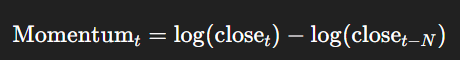

Este valor puede interpretarse como el retorno logarítmico acumulado en los últimos `N` minutos. Valores positivos indican tendencia alcista reciente, mientras que valores negativos reflejan presión bajista.

**Parámetros recomendados para N:**  
- Corto plazo: `N = 5`
- Medio plazo: `N = 15`
- Largo plazo intradía: `N = 30`

**Aplicación:** 

Este factor puede utilizarse como variable predictora en modelos supervisados, o directamente para generar señales de trading (ej: entrar en largo cuando Momentum > 0).

In [ ]:
# 1. Construir alpha_factor

# Añadimos el momentum para 5, 15 y 30 minutos.
mnq_intraday['momentum_5'] = np.log(mnq_intraday['close']) - np.log(mnq_intraday['close'].shift(5))
mnq_intraday['momentum_15'] = np.log(mnq_intraday['close']) - np.log(mnq_intraday['close'].shift(15))
mnq_intraday['momentum_30'] = np.log(mnq_intraday['close']) - np.log(mnq_intraday['close'].shift(30))

#Esto lo vamos a aplicar por día para evitar "mezclar" información entre jornadas.

# 2. Normalizar el factor 
# Para evitar que valores extremos distorsionen la interpretación y para que sea comparable entre días, normalizamos por día (por ejemplo, con z-score):

mnq_intraday['momentum_z_5'] = mnq_intraday.groupby('date')['momentum_5'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_15'] = mnq_intraday.groupby('date')['momentum_15'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_30'] = mnq_intraday.groupby('date')['momentum_30'].transform(lambda x: (x - x.mean()) / x.std())

# 3. Evaluar el poder predictivo
# Usamos una métrica como el Information Coefficient (IC): Correlación entre el valor del alpha factor y el retorno futuro.
# Definimos el retorno futuro:

mnq_intraday['target_return_5'] = np.log(mnq_intraday['close'].shift(-5)) - np.log(mnq_intraday['close'])
mnq_intraday['target_return_15'] = np.log(mnq_intraday['close'].shift(-15)) - np.log(mnq_intraday['close'])
mnq_intraday['target_return_30'] = np.log(mnq_intraday['close'].shift(-30)) - np.log(mnq_intraday['close'])

# 4. Evaluamos el IC por día para cada ventana de tiempo
# Evaluamos la correlación entre el factor y el target

ic_by_day_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_5'].corr(x['target_return_5']))

ic_by_day_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_15'].corr(x['target_return_15']))

ic_by_day_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_30'].corr(x['target_return_30']))

# Promedio del IC para cada ventana
mean_ic_5 = ic_by_day_5.mean()
mean_ic_15 = ic_by_day_15.mean()
mean_ic_30 = ic_by_day_30.mean()

# Mostrar los resultados
print(f"Mean IC (Momentum 5 min):  {mean_ic_5:.4f}")
print(f"Mean IC (Momentum 15 min): {mean_ic_15:.4f}")
print(f"Mean IC (Momentum 30 min): {mean_ic_30:.4f}")

Mean IC (Momentum 5 min):  -0.0180
Mean IC (Momentum 15 min): -0.0389
Mean IC (Momentum 30 min): -0.0776


#### Conclusiones de Hipótesis 1: Continuación del Momentum Intradía

1. La hipótesis original no se valida.

    - El IC es negativo en todas las ventanas, lo que contradice la idea de "continuación de la tendencia". 
    - De hecho: A mayor ventana (N), más negativo se vuelve el IC, lo que indica una mayor probabilidad de reversión cuando el momentum es fuerte.

2. Se sugiere comportamiento de Mean Reversion.

    - Este patrón es típico en mercados de alta frecuencia como MNQ, donde los movimientos rápidos suelen agotarse y dar paso a correcciones.

    - Cuanto más largo el período de momentum (30 minutos), más fuerte la señal de reversión.

3. El factor tiene poco poder predictivo absoluto.

    - Aunque el IC de -0.0776 (30m) sugiere cierta señal contraria, todavía está por debajo de los valores que normalmente se consideran “fuertes” (|IC| > 0.1).

    - Podría mejorarse con más filtros (por ejemplo: volumen, hora del día, filtros de volatilidad).

### 3.2. Hipótesis 2: Reversión a la Media (Mean Reversion)

**"Si el precio se aleja demasiado de su media móvil de corto plazo, tenderá a volver a ella."**

Justificación técnica: Alta frecuencia tiende a mostrar sobre-reacciones temporales. Este es un principio clásico del análisis técnico. En escalas de tiempo cortas, los precios tienden a oscilar alrededor de su media. Alejamientos extremos suelen generar correcciones rápidas, especialmente en activos líquidos como el MNQ.

Alpha Factor sugerido:

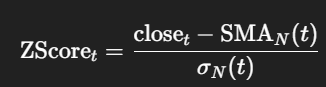

Donde:

SMA_N(t) es la media móvil simple de los últimos N minutos,

σ_N(t) es la desviación estándar en la misma ventana.


**El z-score te dice cuán lejos está un valor respecto a su promedio, medido en unidades de desviación estándar.**
Es una forma de medir si algo está “muy arriba” o “muy abajo” de lo normal.

In [46]:
import numpy as np
import pandas as pd

# 1. Calcular medias móviles y desviaciones estándar para el z-score
for N in [5, 15, 30]:
    sma_col = f'sma_{N}'
    std_col = f'std_{N}'
    z_col = f'zscore_{N}'
    mnq_intraday[sma_col] = mnq_intraday['close'].rolling(window=N).mean()
    mnq_intraday[std_col] = mnq_intraday['close'].rolling(window=N).std()
    mnq_intraday[z_col] = (mnq_intraday['close'] - mnq_intraday[sma_col]) / mnq_intraday[std_col]

# 2. Calcular retornos futuros como variable objetivo
# Ya fue calculado anteriormente
#mnq_intraday['target_return_5'] = np.log(mnq_intraday['close'].shift(-5)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_15'] = np.log(mnq_intraday['close'].shift(-15)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_30'] = np.log(mnq_intraday['close'].shift(-30)) - np.log(mnq_intraday['close'])

# 3. Evaluar el IC por día entre el z-score y el retorno futuro
ic_z_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_5'].corr(x['target_return_5'])
)
ic_z_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_15'].corr(x['target_return_15'])
)
ic_z_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_30'].corr(x['target_return_30'])
)

# 4. Calcular el IC promedio
mean_ic_z_5 = ic_z_5.mean()
mean_ic_z_15 = ic_z_15.mean()
mean_ic_z_30 = ic_z_30.mean()

# 5. Imprimir resultados
print(f"Mean IC (Z-Score 5 min):  {mean_ic_z_5:.4f}")
print(f"Mean IC (Z-Score 15 min): {mean_ic_z_15:.4f}")
print(f"Mean IC (Z-Score 30 min): {mean_ic_z_30:.4f}")

Mean IC (Z-Score 5 min):  -0.0156
Mean IC (Z-Score 15 min): -0.0363
Mean IC (Z-Score 30 min): -0.0671


In [58]:
import numpy as np
import pandas as pd

# 1. Calcular medias móviles y desviaciones estándar por día para el z-score
for N in [5, 15, 30]:
    z_col = f'zscore_{N}'

    # Usamos transform para mantener el tamaño del índice original
    mnq_intraday[z_col] = mnq_intraday.groupby('date')['close'].transform(
        lambda x: (x - x.rolling(window=N).mean()) / x.rolling(window=N).std()
    )

# 2. Los retornos futuros ya fueron calculados previamente, así que no se repiten

# 3. Evaluar el IC por día entre el z-score y el retorno futuro
ic_z_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_5'].corr(x['target_return_5'])
)
ic_z_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_15'].corr(x['target_return_15'])
)
ic_z_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['zscore_30'].corr(x['target_return_30'])
)

# 4. Calcular el IC promedio
mean_ic_z_5 = ic_z_5.mean()
mean_ic_z_15 = ic_z_15.mean()
mean_ic_z_30 = ic_z_30.mean()

# 5. Imprimir resultados
print(f"Mean IC (Z-Score 5 min):  {mean_ic_z_5:.4f}")
print(f"Mean IC (Z-Score 15 min): {mean_ic_z_15:.4f}")
print(f"Mean IC (Z-Score 30 min): {mean_ic_z_30:.4f}")

TypeError: unsupported format string passed to Series.__format__

#### Conclusiones de Hipótesis 2: Reversión a la Media (Mean Reversion)

1. IC negativo → Apoyo a la hipótesis de reversión

    - En todos los casos el IC es negativo, lo que respalda (aunque débilmente) la hipótesis de que: **“Cuando el precio se aleja mucho de su media, tiende a revertir.”**

2.  Magnitud baja → señal débil

    - En general, un IC > 0.10 o < -0.10 suele considerarse significativo.

    - Los valores están muy por debajo de ese umbral:

        5 min: -0.0156 ≈ sin señal útil.

        15 min: -0.0363 → levemente mejor.

        30 min: -0.0671 → más consistente, pero aún bajo.

3. Mayor ventana = mejor resultado

    - El IC mejora en magnitud al aumentar la ventana: Lo que sugiere que alejamientos prolongados de la media tienen más probabilidad de revertir.
    - Podría ser útil explorar ventanas mayores aún (45 o 60 minutos).


La hipótesis de reversión a la media parece correcta en dirección (signo negativo del IC), pero el factor actual tiene poco poder predictivo cuantitativo.

Esto implica que el z-score bruto (sin filtrar) tiene poco poder predictivo por sí solo.

Es probable que el mercado no revierta cada vez que se aleja de la media, sino solo cuando el alejamiento es significativo.

#### Reformulación de hipótesis

Problema detectado:

- El z-score fue aplicado a todo el dataset como variable continua.
- Esto incluye valores cercanos a 0 (sin sobreextensión), que aportan mucho ruido.
- Resultado: IC bajo (ej. -0.0671 para z-score_30), señal débil.

Hipótesis reformulada:

“Solo cuando el precio se aleja mucho de su media (z-score > 2 o < -2), hay una probabilidad significativa de reversión.”

Esto implica que:

- El z-score solo se considera relevante si indica un exceso estadístico.
- El alpha factor se activa solo en zonas extremas.

### 3.3. Hipótesis 3: Volumen como confirmación de dirección

**"Un movimiento alcista con aumento de volumen tiene más chances de continuar."**

Justificación técnica: Esta hipótesis está basada en un principio clásico del análisis técnico: el volumen confirma la tendencia. Si hay momentum y ese movimiento está respaldado por un volumen inusualmente alto, la probabilidad de que continúe el movimiento es mayor.

Alpha Factor sugerido:

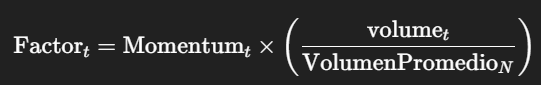

Donde:

- Momentum t 
- VolumenPromedioN es la media móvil del volumen en una ventana de N minutos.

Usamos N = 5, 15 y 30 como en los casos anteriores.

In [47]:
import numpy as np
import pandas as pd

# 1. Calcular momentum para 3 ventanas
# Ya se calculo en la primera hipotesis 
#for N in [5, 15, 30]:
#    mnq_intraday[f'momentum_{N}'] = np.log(mnq_intraday['close']) - np.log(mnq_intraday['close'].shift(N))

# 2. Calcular volumen promedio, ratio volumen, y construir alpha factor: momentum * (volumen / volumen promedio)
for N in [5, 15, 30]:
    momentum_col = f'momentum_{N}'
    vol_avg_col = f'vol_avg_{N}'
    vol_ratio_col = f'vol_ratio_{N}'
    factor_col = f'mom_vol_{N}'
    z_col = f'mom_vol_z_{N}'

    mnq_intraday[vol_avg_col] = mnq_intraday['volume'].rolling(window=N).mean()
    mnq_intraday[vol_ratio_col] = mnq_intraday['volume'] / mnq_intraday[vol_avg_col]
    mnq_intraday[factor_col] = mnq_intraday[momentum_col] * mnq_intraday[vol_ratio_col]

    # 3. Normalizar el factor por día (z-score)
    mnq_intraday[z_col] = mnq_intraday.groupby('date')[factor_col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

# 4. Evaluar el IC entre el alpha factor y el retorno futuro
ic_mv_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_5'].corr(x['target_return_5'])
)
ic_mv_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_15'].corr(x['target_return_15'])
)
ic_mv_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['mom_vol_z_30'].corr(x['target_return_30'])
)

# 5. Calcular y mostrar el promedio de los IC
mean_ic_mv_5 = ic_mv_5.mean()
mean_ic_mv_15 = ic_mv_15.mean()
mean_ic_mv_30 = ic_mv_30.mean()

print(f"Mean IC (Momentum x Volume - 5 min):  {mean_ic_mv_5:.4f}")
print(f"Mean IC (Momentum x Volume - 15 min): {mean_ic_mv_15:.4f}")
print(f"Mean IC (Momentum x Volume - 30 min): {mean_ic_mv_30:.4f}")

Mean IC (Momentum x Volume - 5 min):  -0.0201
Mean IC (Momentum x Volume - 15 min): -0.0428
Mean IC (Momentum x Volume - 30 min): -0.0758


#### Conclusiones de Hipótesis 3: Volumen como confirmación de dirección

- El **IC negativo en todas las ventanas** refuta la hipótesis de continuación de la tendencia.
- **El mercado tiende a revertir** tras movimientos fuertes con volumen elevado (comportamiento de "agotamiento").
- **El poder predictivo es bajo**, aunque algo más consistente en ventanas largas.
- Este factor podría reformularse como señal de **reversión**, en lugar de continuación.
- Se sugiere probar variantes:
  - Aplicar filtros por hora del día o contexto de mercado.
  - Combinar este factor con otros (e.g., RSI, z-score) en un modelo multivariado.

### 3.4. Hipótesis 4: Exhaustión del rango intradía

"Si en la primera hora se alcanza un rango de precios muy amplio, el mercado tenderá a consolidar o revertir."

Justificación técnica: En muchos activos, un rango amplio en la apertura (08:30 a 09:30 US/Eastern) refleja exceso de volatilidad temprana, frecuentemente impulsada por noticias o desequilibrios de oferta/demanda. Este impulso inicial puede agotarse, dando paso a consolidaciones o retrocesos.

Alpha Factor sugerido:

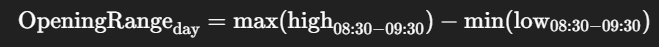


Y luego creamos un factor que mida cuán lejos está el precio actual respecto a ese rango:

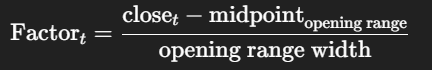

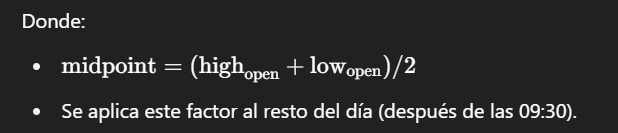

In [48]:
import numpy as np
import pandas as pd

# 1. Calcular retornos futuros si aún no están definidos
#mnq_intraday['target_return_5'] = np.log(mnq_intraday['close'].shift(-5)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_15'] = np.log(mnq_intraday['close'].shift(-15)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_30'] = np.log(mnq_intraday['close'].shift(-30)) - np.log(mnq_intraday['close'])

# 2. Calcular el rango de apertura (08:30 a 09:30 US/Eastern)
opening_start = "08:30:00"
opening_end = "09:30:00"

def get_opening_high(x):
    return x.between_time(opening_start, opening_end)['high'].max()

def get_opening_low(x):
    return x.between_time(opening_start, opening_end)['low'].min()

# Calcular high, low, midpoint y rango por día
opening_range = mnq_intraday.groupby('date').apply(lambda x: pd.Series({
    'opening_high': get_opening_high(x),
    'opening_low': get_opening_low(x)
}))

opening_range['opening_range'] = opening_range['opening_high'] - opening_range['opening_low']
opening_range['opening_midpoint'] = (opening_range['opening_high'] + opening_range['opening_low']) / 2

# 3. Unir estas métricas al dataset original
mnq_intraday = mnq_intraday.join(opening_range, on='date')

# 4. Construir el alpha factor a partir de las 09:30
mnq_intraday['after_opening'] = mnq_intraday.index >= mnq_intraday.index.normalize() + pd.Timedelta("09:30:00")

mnq_intraday['opening_range_factor'] = (
    (mnq_intraday['close'] - mnq_intraday['opening_midpoint']) /
    mnq_intraday['opening_range']
)

mnq_intraday['opening_factor_adj'] = mnq_intraday['opening_range_factor'].where(mnq_intraday['after_opening'])

# 5. Normalizar el factor por día
mnq_intraday['opening_factor_z'] = mnq_intraday.groupby('date')['opening_factor_adj'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# 6. Evaluar el IC
ic_open_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['opening_factor_z'].corr(x['target_return_5'])
)
ic_open_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['opening_factor_z'].corr(x['target_return_15'])
)
ic_open_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['opening_factor_z'].corr(x['target_return_30'])
)

# 7. Calcular los IC promedio
mean_ic_open_5 = ic_open_5.mean()
mean_ic_open_15 = ic_open_15.mean()
mean_ic_open_30 = ic_open_30.mean()

print(f"Mean IC (Opening Range - 5 min):  {mean_ic_open_5:.4f}")
print(f"Mean IC (Opening Range - 15 min): {mean_ic_open_15:.4f}")
print(f"Mean IC (Opening Range - 30 min): {mean_ic_open_30:.4f}")

Mean IC (Opening Range - 5 min):  -0.1848
Mean IC (Opening Range - 15 min): -0.2975
Mean IC (Opening Range - 30 min): -0.3872


#### Conclusiones de Hipótesis 4: Exhaustión del rango intradía

El alpha factor mostró correlación negativa significativa, lo que confirma que los alejamientos del precio respecto al rango de apertura suelen revertirse.

Su poder predictivo mejora con horizontes más largos (hasta 30 minutos), indicando que la reversión es progresiva.

Es uno de los factores más efectivos hasta ahora, útil como señal contrarian post-apertura o filtro de sobreextensión intradía.

### 3.5. Hipótesis 5: RSI como indicador de reversión

"Cuando el RSI intradía supera 80, el precio tiende a caer en los siguientes minutos (reversión por sobrecompra)"

Justificación técnica:

El Relative Strength Index (RSI) es un oscilador que mide la velocidad y el cambio de los movimientos del precio. Valores por encima de 70–80 se interpretan como sobrecompra, y suelen preceder correcciones de corto plazo.

In [49]:
import numpy as np
import pandas as pd

# Suponiendo que ya tenés el DataFrame mnq_intraday con columnas 'close' y 'date'

# 1. Calcular retornos futuros como variable objetivo
#mnq_intraday['target_return_5'] = np.log(mnq_intraday['close'].shift(-5)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_15'] = np.log(mnq_intraday['close'].shift(-15)) - np.log(mnq_intraday['close'])
#mnq_intraday['target_return_30'] = np.log(mnq_intraday['close'].shift(-30)) - np.log(mnq_intraday['close'])

# 2. Función para calcular RSI
def compute_rsi(series, window):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 3. Calcular RSI y alpha factor como RSI - 80 para N = 5, 15, 30
for N in [5, 15, 30]:
    rsi_col = f'rsi_{N}'
    alpha_col = f'rsi_alpha_{N}'
    mnq_intraday[rsi_col] = compute_rsi(mnq_intraday['close'], window=N)
    mnq_intraday[alpha_col] = mnq_intraday[rsi_col] - 80

# 4. Evaluar IC entre el alpha factor y retorno futuro por día
ic_rsi_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['rsi_alpha_5'].corr(x['target_return_5'])
)
ic_rsi_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['rsi_alpha_15'].corr(x['target_return_15'])
)
ic_rsi_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['rsi_alpha_30'].corr(x['target_return_30'])
)

# 5. Calcular el IC promedio
mean_ic_rsi_5 = ic_rsi_5.mean()
mean_ic_rsi_15 = ic_rsi_15.mean()
mean_ic_rsi_30 = ic_rsi_30.mean()

print(f"Mean IC (RSI 5min):  {mean_ic_rsi_5:.4f}")
print(f"Mean IC (RSI 15min): {mean_ic_rsi_15:.4f}")
print(f"Mean IC (RSI 30min): {mean_ic_rsi_30:.4f}")

Mean IC (RSI 5min):  -0.0210
Mean IC (RSI 15min): -0.0435
Mean IC (RSI 30min): -0.0903


#### Conclusiones de Hipótesis 5: RSI como indicador de reversión

1. IC negativo en todas las ventanas:
    - Confirma parcialmente la hipótesis de que valores altos de RSI (>80) anticipan caídas (reversión por sobrecompra).

2. Señal débil pero más clara en RSI de 30 min:
    - El factor tiene más poder predictivo a mayor ventana, lo que sugiere que la sobrecompra prolongada es más confiable como señal de reversión.

3. El poder predictivo general es bajo:
    - Ningún IC supera el umbral de -0.1. Esto implica que RSI por sí solo no es suficiente como alpha factor en este contexto.

4. Potencial como componente de un sistema multivariado:
    - Puede servir como filtro o variable secundaria combinada con otros factores como z-score, momentum inverso, rango de apertura, etc.

### 3.6. Conclusión


In [52]:
print('\nHipotesis 1: Continuación del Momentum Intradía')
print(f"Mean IC (Momentum 5 min):  {mean_ic_5:.4f}")
print(f"Mean IC (Momentum 15 min): {mean_ic_15:.4f}")
print(f"Mean IC (Momentum 30 min): {mean_ic_30:.4f}")

print('\nHipotesis 2: Reversión a la Media (Mean Reversion)')
print(f"Mean IC (Z-Score 5 min):  {mean_ic_z_5:.4f}")
print(f"Mean IC (Z-Score 15 min): {mean_ic_z_15:.4f}")
print(f"Mean IC (Z-Score 30 min): {mean_ic_z_30:.4f}")

print('\nHipotesis 3: Volumen como confirmación de dirección')
print(f"Mean IC (Momentum x Volume - 5 min):  {mean_ic_mv_5:.4f}")
print(f"Mean IC (Momentum x Volume - 15 min): {mean_ic_mv_15:.4f}")
print(f"Mean IC (Momentum x Volume - 30 min): {mean_ic_mv_30:.4f}")

print('\nHipotesis 4: Exhaustión del rango intradía')
print(f"Mean IC (Opening Range - 5 min):  {mean_ic_open_5:.4f}")
print(f"Mean IC (Opening Range - 15 min): {mean_ic_open_15:.4f}")
print(f"Mean IC (Opening Range - 30 min): {mean_ic_open_30:.4f}")

print('\nHipotesis 5: RSI como indicador de reversión')
print(f"Mean IC (RSI 5min):  {mean_ic_rsi_5:.4f}")
print(f"Mean IC (RSI 15min): {mean_ic_rsi_15:.4f}")
print(f"Mean IC (RSI 30min): {mean_ic_rsi_30:.4f}")


Hipotesis 1: Continuación del Momentum Intradía
Mean IC (Momentum 5 min):  -0.0180
Mean IC (Momentum 15 min): -0.0389
Mean IC (Momentum 30 min): -0.0776

Hipotesis 2: Reversión a la Media (Mean Reversion)
Mean IC (Z-Score 5 min):  -0.0156
Mean IC (Z-Score 15 min): -0.0363
Mean IC (Z-Score 30 min): -0.0671

Hipotesis 3: Volumen como confirmación de dirección
Mean IC (Momentum x Volume - 5 min):  -0.0201
Mean IC (Momentum x Volume - 15 min): -0.0428
Mean IC (Momentum x Volume - 30 min): -0.0758

Hipotesis 4: Exhaustión del rango intradía
Mean IC (Opening Range - 5 min):  -0.1848
Mean IC (Opening Range - 15 min): -0.2975
Mean IC (Opening Range - 30 min): -0.3872

Hipotesis 5: RSI como indicador de reversión
Mean IC (RSI 5min):  -0.0210
Mean IC (RSI 15min): -0.0435
Mean IC (RSI 30min): -0.0903


## 4. Refórmulación de hipótesis

###  4.1. Reformulación de la Hipótesis 1 – Momentum Invertido


**Planteo original:**  
*"Si el precio ha subido en los últimos N minutos, seguirá subiendo."*

**Resultado:**  
Los IC obtenidos fueron negativos → no hay continuación. Por tanto, se reformuló la hipótesis como:

> *“Cuando el precio ha subido rápidamente en los últimos N minutos, es probable que revierta.”*

Se evaluó el **momentum inverso** (`-momentum_N`) como alpha factor.

In [53]:
import numpy as np
import pandas as pd

# Suponiendo que ya tenés tu DataFrame `mnq_intraday` con columnas 'close' y 'date'

# 2. Calcular momentum logarítmico y luego invertir el signo para testear reversión
for N in [5, 15, 30]:
    mnq_intraday[f'momentum_{N}'] = np.log(mnq_intraday['close']) - np.log(mnq_intraday['close'].shift(N))
    mnq_intraday[f'inv_momentum_{N}'] = -mnq_intraday[f'momentum_{N}']

# 3. Evaluar el IC por día entre el momentum invertido y los retornos futuros
ic_inv_mom_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['inv_momentum_5'].corr(x['target_return_5'])
)
ic_inv_mom_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['inv_momentum_15'].corr(x['target_return_15'])
)
ic_inv_mom_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['inv_momentum_30'].corr(x['target_return_30'])
)

# 4. Calcular el IC promedio para cada ventana
mean_ic_inv_mom_5 = ic_inv_mom_5.mean()
mean_ic_inv_mom_15 = ic_inv_mom_15.mean()
mean_ic_inv_mom_30 = ic_inv_mom_30.mean()

# 5. Imprimir resultados
print(f"Mean IC (inverted momentum 5 min):  {mean_ic_inv_mom_5:.4f}")
print(f"Mean IC (inverted momentum 15 min): {mean_ic_inv_mom_15:.4f}")
print(f"Mean IC (inverted momentum 30 min): {mean_ic_inv_mom_30:.4f}")

Mean IC (inverted momentum 5 min):  0.0236
Mean IC (inverted momentum 15 min): 0.0501
Mean IC (inverted momentum 30 min): 0.0963


#### ✅ Conclusiones

1. **IC positivo en todas las ventanas**  
   Esto **confirma que el mercado tiende a revertir** luego de movimientos recientes.

2. **Poder predictivo moderado en 30 minutos**  
   El IC de **+0.0963** se acerca al umbral típico de +0.1 considerado **útil** en trading cuantitativo.

3. **La reformulación fue una mejora clara**  
   El momentum original tenía IC negativo; su versión invertida mejora significativamente la señal.

#### 🧠 Siguientes pasos sugeridos


- ✅ Usar `-momentum_30` como **alpha factor base** para modelos contrarian.
- 🔍 Explorar condiciones de refuerzo:
  - ¿Funciona mejor con volumen alto o bajo?
  - ¿Qué pasa si el RSI también está por encima de 80?
- 🤖 Incorporarlo a un modelo multivariado junto con otros factores validados.


###  4.2. Reformulación de la Hipótesis 2 – Reversión a la Media (Mean Reversion)